<a href="https://colab.research.google.com/github/leoclementliao/effdet_wheat/blob/master/E0_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies and imports

In this kernel used github repos [efficientdet-pytorch](https://github.com/rwightman/efficientdet-pytorch) and [pytorch-image-models](https://github.com/rwightman/pytorch-image-models) by [@rwightman](https://www.kaggle.com/rwightman). Don't forget add stars ;)

In [1]:
!/opt/bin/nvidia-smi

Fri Jul 17 22:09:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!rm -r /content/EffecientDet

rm: cannot remove '/content/EffecientDet': No such file or directory


In [4]:
mixup_ratio=0.5
# mix_alpha = 0.5 # bbox image * mix_alpha
random_seed = 42
version_name = 'E0_baseline'
input_weight_name = 'efficientdet_d5-ef44aea8.pth'
checkpoint = '/content/drive/My Drive/Colab Notebooks/kaggle_Wheat/weights/'+version_name

In [5]:
# !pip install ensemble-boxes

## copy effdet model
!cp -r '/content/drive/My Drive/Colab Notebooks/kaggle_Wheat/EffecientDet' ./
%cd EffecientDet
!unzip timm-efficientdet-pytorch.zip -d timm-efficientdet-pytorch

## copy pretrain weight
!cp '/content/drive/My Drive/Colab Notebooks/kaggle_Wheat/weights/{input_weight_name}' ./

## copy wheat data
!cp '/content/drive/My Drive/Colab Notebooks/kaggle_Wheat/data/global-wheat-detection.zip' ./
!unzip global-wheat-detection.zip -d global-wheat-detection
!cp '/content/drive/My Drive/Colab Notebooks/kaggle_Wheat/data/adv_data_all.zip' ./
!unzip adv_data_all.zip -d ./


/content/EffecientDet
Archive:  timm-efficientdet-pytorch.zip
  inflating: timm-efficientdet-pytorch/LICENSE  
  inflating: timm-efficientdet-pytorch/README.md  
  inflating: timm-efficientdet-pytorch/avg_checkpoints.py  
  inflating: timm-efficientdet-pytorch/data/__init__.py  
  inflating: timm-efficientdet-pytorch/data/dataset.py  
  inflating: timm-efficientdet-pytorch/data/loader.py  
  inflating: timm-efficientdet-pytorch/data/transforms.py  
  inflating: timm-efficientdet-pytorch/distributed_train.sh  
  inflating: timm-efficientdet-pytorch/effdet/__init__.py  
  inflating: timm-efficientdet-pytorch/effdet/anchors.py  
  inflating: timm-efficientdet-pytorch/effdet/bench.py  
  inflating: timm-efficientdet-pytorch/effdet/config/config.py  
  inflating: timm-efficientdet-pytorch/effdet/efficientdet.py  
  inflating: timm-efficientdet-pytorch/effdet/helpers.py  
  inflating: timm-efficientdet-pytorch/effdet/loss.py  
  inflating: timm-efficientdet-pytorch/effdet/object_detection/RE

In [6]:
!pip install ensemble-boxes
!pip install timm
!pip install albumentations==0.4.6
!pip install pycocotools
!pip install omegaconf

# !pip install effdet 
# !pip install scikit-optimize

     |████████████████████████████████| 215kB 5.7MB/s 
     |████████████████████████████████| 122kB 5.2MB/s 
     |████████████████████████████████| 952kB 16.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65164 sha256=39f60cf98f329a3ce03485f2d63959f2f371ec824ab5bc4393fe94af2d7c2646
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [7]:
import sys
sys.path.insert(0, "./timm-efficientdet-pytorch")
# sys.path.insert(0, "./omegaconf")
# sys.path.insert(0, "./weightedboxesfusion")

In [8]:
# 导入依赖的库
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import random
import cv2
import torch
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, Dataset,RandomSampler,SequentialSampler
import os
import time
import datetime
import glob
import warnings
warnings.filterwarnings("ignore")

In [9]:
# 导入数据
marking = pd.read_csv(r'./global-wheat-detection/train.csv')
marking.head(2)

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1


In [10]:
def delete_add(df, delete_index, add_xywh, delete=True):
    replaces = []
    for xywh in add_xywh:
        replace = df.iloc[[delete_index]].copy()
        replace[['x','y','w','h']] = xywh
        replaces.append(replace)
    replaces = pd.concat(replaces)
    if delete:
        df = df.drop(index=delete_index)
    df = pd.concat([df, replaces]).reset_index(drop=True)
    return df

df = pd.read_csv(r'./global-wheat-detection/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df = delete_add(df, 173, [[0,15,140,70],[288,270,80,150]]) #"41c0123cc"
df = delete_add(df, 2158, [[10,449,320,68],[85,530,300,80],[290,430,225,200],[640,110,110,80]]) #"a1321ca95"
df = delete_add(df, 2167, [[137,610,270,220]]) #"a1321ca95"
df = delete_add(df, 3684, [[37,84,90,140]]) #"2cc75e9f5"
df = delete_add(df, 52864, [[3,470,210,180],[213,280,250,200]]) #"9a30dd802"
df = delete_add(df, 113942, [[262,645,70,70]]) #"42e6efaaa"
df = delete_add(df, 117338, [[492,268,100,100]]) #"409a8490c"
df = delete_add(df, 118204, [[922,857,46,58]]) #"d7a02151d"
df = delete_add(df, 121625,  [[0,673,55,64],[575,133,129,69]]) #"d067ac2b1"
df = delete_add(df, 121625, [[672,37,155,107],[770,313,210,80]]) #"d067ac2b1"
df = delete_add(df, 147494, [[325,62,94,77]]) #"d60e832a5"
df = delete_add(df, 120729, [[890,890,133,133]], False) #"d8cae4d1b"

In [11]:
# 注意 bbox 是一个 string 类型，所以需要将它转换为 ndarray
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
# bboxs = np.stack(marking['bbox'].apply(lambda x: eval(x)))

In [12]:
bboxs

array([[834., 222.,  56.,  36.],
       [226., 548., 130.,  58.],
       [377., 504.,  74., 160.],
       ...,
       [134., 228., 141.,  71.],
       [430.,  13., 184.,  79.],
       [875., 740.,  94.,  61.]])

In [13]:
# 将 bbox 转换为 x,y,w,h 四列，然后删除 bbox 列
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [14]:
marking.head(2)

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0


In [15]:
# 利用 sklearn 生成 5 折的分层交叉验证的实例。
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [16]:
# 复制 image_id 
df_folds = marking[['image_id']].copy()

In [17]:
# 设定每一个 image_id 的 bbox个数（这个时候image_id 是有重复的）
df_folds.loc[:, 'bbox_count'] = 1

In [18]:
# 按照 image_id 聚合，得到每一个 image_id 的 bbox 的个数
df_folds = df_folds.groupby('image_id').count()

In [19]:
# 取 source
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']

In [20]:
# 按照 source 和 bbox_count 的个数划分为了 34 个 group  
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)

In [21]:
np.unique(df_folds.stratify_group)
# 这么做的目的来源于两个方面。
# 1. 需要保证划分的多折训练集中数据来源占比一致。
# 2. 需要保证划分的多折训练集中 bbox 分布大致一致。 

array(['arvalis_1_0', 'arvalis_1_1', 'arvalis_1_2', 'arvalis_1_3',
       'arvalis_1_4', 'arvalis_1_5', 'arvalis_1_6', 'arvalis_2_0',
       'arvalis_2_1', 'arvalis_2_2', 'arvalis_3_0', 'arvalis_3_1',
       'arvalis_3_2', 'arvalis_3_3', 'arvalis_3_4', 'arvalis_3_5',
       'ethz_1_2', 'ethz_1_3', 'ethz_1_4', 'ethz_1_5', 'ethz_1_6',
       'ethz_1_7', 'inrae_1_0', 'inrae_1_1', 'inrae_1_2', 'rres_1_1',
       'rres_1_2', 'rres_1_3', 'rres_1_4', 'rres_1_5', 'usask_1_0',
       'usask_1_1', 'usask_1_2', 'usask_1_3'], dtype=object)

In [22]:
# 设定默认的 fold 为 0 
df_folds.loc[:, 'fold'] = 0

In [23]:
# 进行分层的交叉验证，将 ‘stratify_group’ 做为 y。这样就保证了划分的一致性。
for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

In [24]:
df_folds.head(5)

,bbox_count,source,stratify_group,fold
image_id,,,,
00333207f,55,arvalis_1,arvalis_1_3,1
005b0d8bb,20,usask_1,usask_1_1,3
006a994f7,25,inrae_1,inrae_1_1,1
00764ad5d,41,inrae_1,inrae_1_2,0
00b5fefed,25,arvalis_3,arvalis_3_1,3


---

[albumentations数据增强包官方文档](https://albumentations.readthedocs.io/en/latest/)

- Compose 函数为要对图像实行的变换。 Compose 包含图像的变换和 Bbox 的变换。
- p 为实现该变换的概率。
- OneOf 表示只选择一个变换来实现，这个时候概率需要归一化。
- min_area 表示 Bbox 所占像素小于这个值的会被抛弃掉。
- min_visibility 表示 Bbox 占图片比例小于这个值的会被抛弃掉。

In [25]:
# 训练集阶段的数据增强变换
# 依托于 albumentations 这个三方包
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit= 0.3,
                                     val_shift_limit=0.3, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.4,
                                           contrast_limit=0.3, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.01),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )

# 验证集阶段的数据增强变换
# 依托于 albumentations 这个三方包
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ],
        p=1.0,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0,
            min_visibility=0,
            label_fields=['labels']
        )
    )


In [27]:
# 训练数据所在路径
TRAIN_ROOT_PATH = r'./global-wheat-detection/train'
EXTERNAL_DATA = './adv_data_all'

# Torch 的数据生成器 
class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()
        
        # 图片的 ID 列表
        self.image_ids = image_ids
        # 图片的标签和基本信息
        self.marking = marking
        # 图像增强
        self.transforms = transforms
        # 测试集
        self.test = test
        
        # Mosaic and mixuo
        self.image_external = glob.glob(EXTERNAL_DATA+'/*.jpg')
        self.mosaic_border = (0,0)
        self.img_size = 1024
        self.mixup_ratio = 0.5
        self.min_box_surf = 100 #pix*pix

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        # 百分之 50 的概率会做 mix up
        if self.test or random.random() > 1:
            # 具体定义在后面
            image, boxes = self.load_image_and_boxes(index)
        else:
#             # 具体定义在后面
# #             image, boxes = self.load_mixup_image_and_boxes(index)
#             image, boxes = self.load_mixup_image(index)
            image, boxes = self.load_mosaic_mixup(index)        
        # 这里只有一类的目标定位问题，标签数量就是 bbox 的数量
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        
        # 多做几次图像增强，防止有图像增强失败，如果成功，则直接返回。
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:, [0, 1, 2, 3]] = target['boxes'][:, [1, 0, 3, 2]]  # yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        # 加载 image_id 名字
        image_id = self.image_ids[index]
        # 加载图片
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # 转换图片通道 从 BGR 到 RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # 0,1 归一化
        image /= 255.0
        # 获取对应 image_id 的信息
        records = self.marking[self.marking['image_id'] == image_id]
        # 获取 bbox
        boxes = records[['x', 'y', 'w', 'h']].values
        # 转换成模型输入需要的格式
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

    def load_mixup_image_and_boxes(self,index,imsize=1024):
        # 加载图片和 bbox
        image, boxes = self.load_image_and_boxes(index)
        # 随机加载另外一张图片和 bbox
        r_image, r_boxes= self.load_image_and_boxes(random.randint(0, self.image_ids.shape[0] - 1))
        # 进行 mixup 图片的融合，这里简单的利用 0.5 权重
        mixup_image = (image + r_image) / 2
        # 进行 mixup bbox的融合
        mixup_boxes = np.concatenate((boxes,r_boxes),0)
        return mixup_image, mixup_boxes
    
    ## Only mixup with texture image
    def load_image_external(self, index):
        # 加载 image_id 名字
        image_id = self.image_external[index]
        # 加载图片
        image = cv2.imread(image_id, cv2.IMREAD_COLOR)
        # 转换图片通道 从 BGR 到 RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # 0,1 归一化
        image /= 255.0
        return image
    
    def load_mixup_image(self,index,imsize=1024):
        mix_alpha = 0.5
        image, boxes = self.load_image_and_boxes(index)
        indice_external = random.randint(0, len(self.image_external) - 1)
        image_external = self.load_image_external(indice_external)
        mixup_image = cv2.addWeighted(image_external, mix_alpha, image, 1-mix_alpha,0)
        
        return mixup_image, boxes

    ## Mosaic + Mixup
    def load_mosaic_mixup(self, index): ## add mixup (meng-liao)
        boxes4 = []
        s = self.img_size//2
        yc, xc = [int(random.uniform(-x, 2 * s + x)) for x in self.mosaic_border]  # mosaic center x, y
        indices = [index] + [random.randint(0, len(self.image_ids) - 1) for _ in range(3)]  # 3 additional image indices
        for i, index in enumerate(indices):
            # Load mixed image
            if random.uniform(0,1)<self.mixup_ratio:
                img, boxes = self.load_mixup_image(index)
            else:
                img, boxes = self.load_image_and_boxes(index)
            h, w = img.shape[:2]
            
            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 0.5, dtype='float32')  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
            padw = x1a - x1b
            padh = y1a - y1b
            
            # mosaic boxes
            boxes_mosaic = boxes.copy()
            if boxes.size > 0:
                boxes_mosaic[:, 0] = boxes[:, 0] + padw
                boxes_mosaic[:, 1] = boxes[:, 1] + padh
                boxes_mosaic[:, 2] = boxes[:, 2] + padw
                boxes_mosaic[:, 3] = boxes[:, 3] + padh
            boxes4.append(boxes_mosaic)
        
        # Concat/clip labels
        if len(boxes4):
            boxes4 = np.concatenate(boxes4, 0)
            # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
            
            ## boundary crop
            np.clip(boxes4, 0, 2 * s, out=boxes4)  
            boxes4 = boxes4[(boxes4[:,2]-boxes4[:,0])*(boxes4[:,3]-boxes4[:,1])>self.min_box_surf,:]

#         plt.figure()
#         plt.imshow(img4)
#         plt.title('img4')
        return img4, boxes4


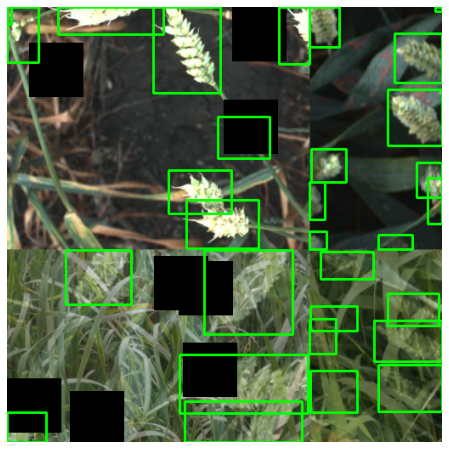

In [28]:
# 取第 0 折为验证集，其余 4 折为训练集
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

# 验证一下生成器得到的训练数据是否正确
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)
numpy_image = image.permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(16, 8));
for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3], box[2]), (0, 1, 0), 2);
ax.set_axis_off()
ax.imshow(numpy_image)


In [29]:
# 计算平均损失的类
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [30]:
# 模型训练类
class Fitter:
    # 初始化
    def __init__(self, model, device, config):
        # 模型各类参数
        self.config = config
        # epoch的初始值
        self.epoch = 0
        # 保存模型的地址
        self.base_dir = config.folder
        # 如果不存在则新增对应目录
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)
        
        # 打印 log 的地址，保存模型的训练信息
        self.log_path = f'{self.base_dir}/log.txt'
        # 设定一个比较大的 best_summary_loss 值，为了保存最优的模型
        self.best_summary_loss = 10 ** 5

        self.model = model
        self.device = device
        
        # 确定哪些值需要加weight_decay （正则项值）
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
        # 优化算法使用 RMS
        # 学习策略
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')
    
    # 模型训练
    def fit(self, train_loader, validation_loader):
        # 训练 n_epochs 次
        for e in range(self.config.n_epochs):
            # 在日志中记录信息
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.datetime.now().utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')
            
            # 开始训练一个 epoch
            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            # 得到验证集合的损失
            summary_loss = self.validation(validation_loader)

            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            # 如果验证的损失比最优的好，则保存最优的模型
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                # 切换到模型的验证模式
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')

            # 执行学习策略（相当于 callback 函数）
            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
    
    # 获得验证集的结果
    def validation(self, val_loader):
        # 切换到模型的验证模式
        self.model.eval()
        # 初始化损失计算器
        summary_loss = AverageMeter()
        t = time.time()
        # 开始遍历验证集
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                images = torch.stack(images)
                batch_size = images.shape[0]
                images = images.to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        # 切换到模型的训练模式
        self.model.train()
        # 初始化损失计算器
        summary_loss = AverageMeter()
        t = time.time()
         # 开始遍历训练集
        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )

            images = torch.stack(images)
            images = images.to(self.device).float()
            batch_size = images.shape[0]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            self.optimizer.zero_grad()
            # 前向传播计算 loss
            loss, _, _ = self.model(images, boxes, labels)
            # 反向传播计算 grad
            loss.backward()
            # 更新 loss
            summary_loss.update(loss.detach().item(), batch_size)
            # 根据优化算法更新 parameter
            self.optimizer.step()
            # 执行学习策略
            if self.config.step_scheduler:
                self.scheduler.step()

        return summary_loss
    
    # 保存模型
    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)
    
    # 加载模型
    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1
    
    # 打印日志
    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

In [31]:
# 各类超参数
class TrainGlobalConfig:
    num_workers = 2
    batch_size = 4
    n_epochs = 60  # n_epochs = 40
    lr = 0.0004

    folder = checkpoint

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    # 我们只在每次 epoch 完，验证完后，再执行学习策略。
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

    # 当指标变化小时，减少学习率
    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=1,
        verbose=False,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )
    # ---

In [32]:
# 数据加载器
def collate_fn(batch):
    return tuple(zip(*batch))

def run_training():
    device = torch.device('cuda:0')
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    fitter.fit(train_loader, val_loader)

In [33]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet

def get_net():
    # 模型的配置，这个返回的是一个字典
    config = get_efficientdet_config('tf_efficientdet_d5')
    # 根据上面的配置生成网络
    net = EfficientDet(config, pretrained_backbone=False)
    # 加载预训练模型
    checkpoint = torch.load(r'./efficientdet_d5-ef44aea8.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    # norm_kwargs 设置的是 BATCHNORM2D 的参数
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)
if __name__ == '__main__':
    net = get_net()

    run_training()

Fitter prepared. Device is cuda:0

2020-07-17T22:11:21.571747
LR: 0.0004
[RESULT]: Train. Epoch: 0, summary_loss: 0.89691, time: 415.04792
[RESULT]: Val. Epoch: 0, summary_loss: 0.50966, time: 28.32370

2020-07-17T22:18:46.921209
LR: 0.0004
[RESULT]: Train. Epoch: 1, summary_loss: 0.61653, time: 413.20673
[RESULT]: Val. Epoch: 1, summary_loss: 0.44798, time: 28.28619

2020-07-17T22:26:10.560118
LR: 0.0004
[RESULT]: Train. Epoch: 2, summary_loss: 0.59026, time: 414.24462
[RESULT]: Val. Epoch: 2, summary_loss: 0.49603, time: 28.54413

2020-07-17T22:33:34.514217
LR: 0.0004
[RESULT]: Train. Epoch: 3, summary_loss: 0.57351, time: 413.80321
[RESULT]: Val. Epoch: 3, summary_loss: 0.42841, time: 28.18883

2020-07-17T22:40:58.565141
LR: 0.0004
[RESULT]: Train. Epoch: 4, summary_loss: 0.55707, time: 412.11352
[RESULT]: Val. Epoch: 4, summary_loss: 0.42540, time: 28.12420

2020-07-17T22:48:20.872509
LR: 0.0004
[RESULT]: Train. Epoch: 5, summary_loss: 0.55527, time: 410.33589
[RESULT]: Val. Epoch: